In [16]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time

sys.path.insert(1, '../test_premier_model/')
# hand made functions
from Rouss1 import *
from Rouss2 import *

sys.path.insert(1,"../../Model_val/upscalling/")
#upscalling functions
from upscalling_functions import *

In [17]:
model_dir = "working"
model_name = "import_MPS"
exe_name= "../../exe/mf6"

In [18]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../data/MNT/MNT_50.tif"

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

#MPS and up

pathsimu = "../../Model_val/upscalling/simu_np.pickle"


In [19]:
%%time
# import simu and upscalling
simu = read_pickle(pathsimu)

# assign k values 
facies_list = [0,1,2,3,4,5]

kh = (1e-7,1e-3,1e-3,1e-5,1e-4,1e-5)
k_list      = [kh[0],kh[1],kh[2],kh[3],kh[4],kh[5]]
simu_k      = assign_k(simu, facies_list, k_list)

# upscalling
sx = 100
sy = 100
sx_up = 400
sy_up = 400
simu_up = up_array_mean(simu_k, sx, sy, sx_up = sx_up, sy_up = sy_up)


The shape of the ouptut grid is (128, 103)
Upscalling is done!
Wall time: 2.06 s


In [88]:
#spatial parameters

#x0,y0
x0 = 664328.1865 # input manuel
y0 = 6153000.2413
x1 = x0 + read_pickle(pathsimu).shape[1]*100 # input manuel
y1 = y0 + read_pickle(pathsimu).shape[0]*100

nlay = 1
nrow = simu_up.shape[0]
ncol = simu_up.shape[1]
delc = sy_up
delr =  sx_up


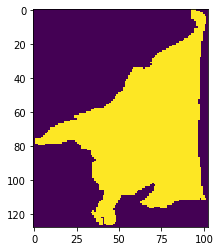

In [21]:
#create mask
idomain = np.flipud(create_mask(simu_up)).reshape(nrow*ncol)
plt.imshow(idomain.reshape(nrow,ncol))

In [24]:
#lst domain
lst_domain=[]
for irow in range(nrow):
    for icol in range(ncol):
        if idomain[irow*ncol + icol] == 1:
            lst_domain.append((0,irow,icol))

In [46]:
# load top data----------------------------------------------------------------------------------------------------------
MNT = Raster.load(MNT_path)

grid = fp.discretization.StructuredGrid(delc*np.ones([nrow]),delr*np.ones([ncol]),xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                 # to pre-process data

top = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")


### load botom based on the differents surfaces--------------------------------------------------------------------------
folder_path = "../../data/txt_couches_nouv"
surfaces = []
for file in glob.glob(os.path.join(folder_path, '*.txt')):
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))

Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
BOT = PMS.copy()
BOT[PMS==-9999] = PC[PMS==-9999]
BOT[PC==-9999] = Q[PC==-9999]
BOT[BOT==-9999] = top[BOT==-9999] - 50

BOT[(top-BOT)<=10] = top[(top-BOT)<=10] - 10 # minimum of 10 m thickness to avoid bug and numerical issues
BOT = BOT+5

In [28]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [29]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [30]:
# BC Agly
Agy_chd = Complete_riv(Agly_path,Agly_stations,us=28,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [31]:
# BC Tet
Tet_chd = Complete_riv(Tet_path,Tet_stations,us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [32]:
#BC Boul
Bol_chd = Complete_riv(Bol_path,Bol_stations,us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [33]:
## BC Reart
Rea_chd = Complete_riv(Rea_path,Rea_stations,us=130,ds=0,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [34]:
## BC Cant
Cant_chd = Complete_riv(Cant_path,Cant_stations,us=135,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [35]:
# BC Tech
Tech_chd = Complete_riv(Tech_path,Tech_stations,us=170,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [36]:
# extraction
path = "../../data/prélèvements/prlvm_brl/Prlvm_brl_Rou.shp"
V_col = "V Bancaris"
layer = 0
stress_data_well = importWells(path,grid,lst_domain,V_col=V_col,layer=layer)

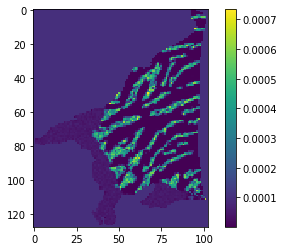

In [40]:
# permea
k = np.flipud(simu_up)
k[np.isnan(k)] = 1e-4
a = plt.imshow(k)
plt.colorbar()

In [41]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="1990",np_col="NP",x_col="x",y_col="y")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [84]:
# recharge areas
path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(path,grid)

# prevent recharge on cells with a very low conductivity

coeff = rcha[idomain.reshape(nrow,ncol)==1].sum()/(rcha[idomain.reshape(nrow,ncol)==1].sum()-rcha[k<1e-7].sum())
rcha[k<1e-7]=0
rcha[k>1e-7]*=coeff

In [89]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='moderate')


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k, save_flows=True,save_specific_discharge=True)


# recharge
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
   
    
# well package
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="{}.wel".format(model_name),
                           stress_period_data=stress_data_well, maxbound=len(stress_data_well))

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

#drn = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname='drn', maxbound=len(lst_drn), 
#                                               stress_period_data={0: lst_drn}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [90]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model import_MPS...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package wel...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been sub

(True, [])

# Inversion
##### The simulation is composed of 6 facies:
0 = plaine innondation

1 = rivière en tresse

2 = rivière en méandre

3 = crevasse splay

4 = cone alluvial

5 = levee

In [68]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    facies_list = [0,1,2,3,4,5]
    k_list      = [kh[5],kh[4],kh[3],kh[0],kh[1],kh[2]]
    simu_k      = assign_k(simu, facies_list, k_list)

    # upscalling
    simu_up = up_array_mean(simu_k, sx, sy, sx_up = sx_up, sy_up = sy_up)
    
    k = np.flipud(simu_up)
    k[np.isnan(k)]=1e-4
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k) # create the new npf package
    npf.write() # write it
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=0
    
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])))

In [69]:
kh = (1e-7,1e-3,1e-3,1e-6,1e-5,1e-5)
res = minimize(Misfit,[kh], method = 'Nelder-Mead')

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling is done!
The shape of the ouptut grid is (128, 103)
Upscalling i

In [70]:
res

 final_simplex: (array([[1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05],
       [1.01426668e-07, 9.98476407e-04, 9.73374373e-04, 9.82773770e-07,
        1.04838877e-05, 1.04523376e-05]]), array([7.00059947, 7.10518064, 7.17026049, 7.22163472, 7.29958193,
       7.3332281 , 7.42580664]))
           fun: 7.000599468141716
       message: 'Maximum number of function evaluations 

In [91]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

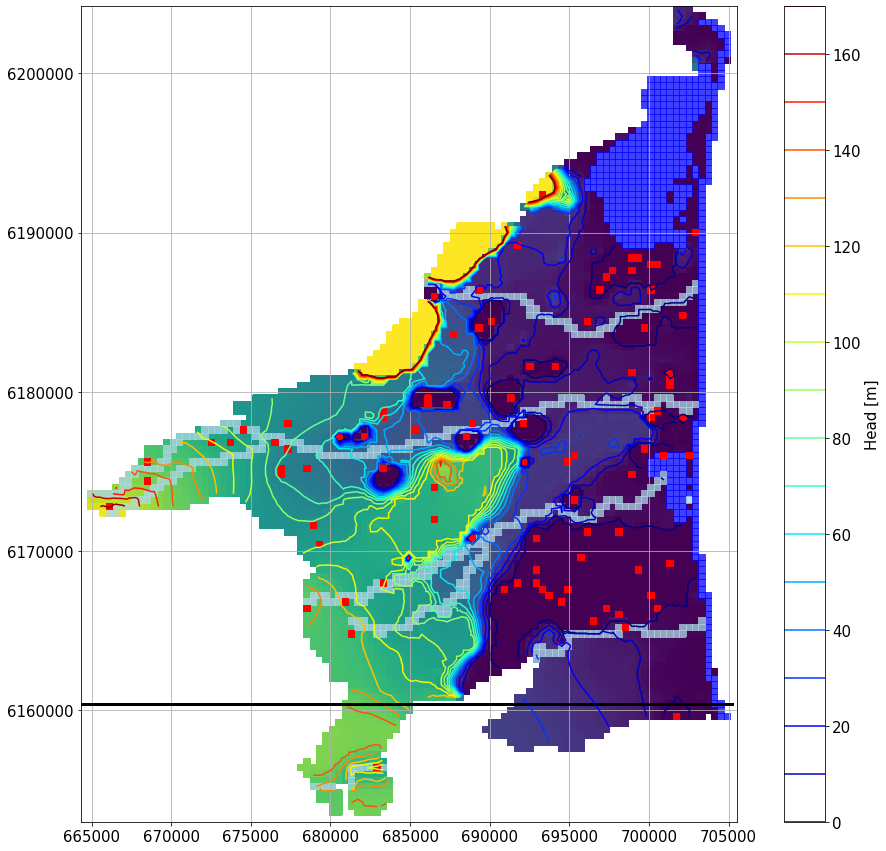

In [92]:
# make a plot
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.plot_array(head,masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,180)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)
ml.plot_bc("wel") # plot the wells  

# plot Cross-section
row = 109
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

Text(0.5, 1.0, 'fit measured vs simulated')

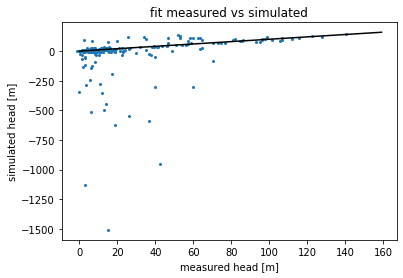

In [93]:
head[head>1000]=0
plt.scatter(Control_pz[Control_pz!=0],
            head[0][Control_pz!=0],s=4)
plt.plot(np.arange(160),np.arange(160),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")

In [94]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit : 66.02151679879873 m 


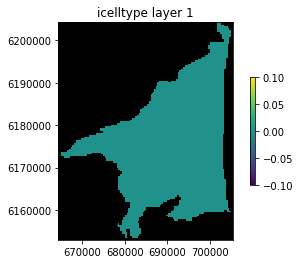

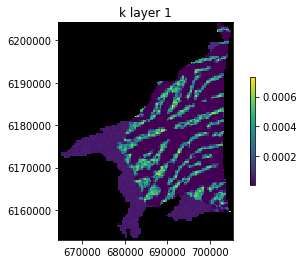

In [95]:
npf.plot()

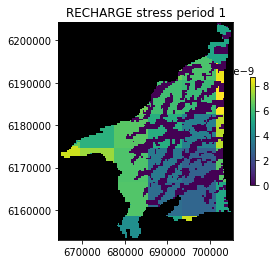

In [96]:
rch.plot()